In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import time
import glob
from PIL import Image

/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/

In [2]:
folder_path = './'
subfolder_path = 'duck_pics/'
save_folder = 'duck_model/'

img_size = 101
l2_alpha = 1e-2
l2_regularizer = False
save_mode = True

num_epochs = 100
batch_size = 64
lr = 0.00005

L2_LAMBDA = 0.01


In [3]:
train_image, train_label, test_image, test_label = [], [], [], []
#train_image, train_label = [], []
i = 0
for image_name in os.listdir(folder_path + subfolder_path):
    if i % 9 == 0:
        img = cv2.imread(os.path.join(folder_path, subfolder_path, image_name))
        test_image.append(cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC))
        test_label.append("1")
    else:
        img = cv2.imread(os.path.join(folder_path, subfolder_path, image_name))
        train_image.append(cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC))
        train_label.append("1")
    i += 1

for image_name in os.listdir("./no_obs_outer"):
    if "jpg" not in image_name:
        continue
    if i % 9 == 0:
        img = cv2.imread(os.path.join("./no_obs_outer", image_name))
        test_image.append(cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC))
        test_label.append("0")
    else:
        img = cv2.imread(os.path.join("./no_obs_outer", image_name))
        train_image.append(cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC))
        train_label.append("0")
    i += 1


In [4]:
# train_image, train_label, test_image, test_label = [], [], [], []

# with open(folder_path + subfolder_path + 'train.txt', 'r') as f:
#     temp = [l.split(' ') for l in f.read().splitlines()]
# f.close()

# for l in temp:
#     img = cv2.imread(folder_path + l[0])
#     train_image.append(cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC))
#     train_label.append(l[1])    
    
# with open(folder_path + subfolder_path + 'test.txt', 'r') as f:
#     temp = [l.split(' ') for l in f.read().splitlines()]
# f.close()

# for l in temp:
#     img = cv2.imread(folder_path + l[0])
#     test_image.append(cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC))
#     test_label.append(l[1])

train_label = np.array(train_label).astype(np.int)
test_label = np.array(test_label).astype(np.int)

picture_train = (np.array(train_image).astype(np.float32) - 127.5) / 127.5
picture_test = (np.array(test_image).astype(np.float32) - 127.5) / 127.5

train_label_one_hot = np.zeros((len(train_label), 2)).astype(np.int32)
test_label_one_hot = np.zeros((len(test_label), 2)).astype(np.int32)
for i in range(len(train_label)):
    train_label_one_hot[i, train_label[i]] = 1
for i in range(len(test_label)):
    test_label_one_hot[i, test_label[i]] = 1

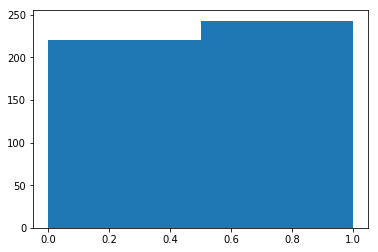

In [5]:
plt.hist(train_label, bins=2)
plt.show()

In [6]:
# #img = tf.Variable(train_image[:2]) # img shape is [580,580,3]
# img = tf.placeholder(dtype=tf.float32,shape=[None, img_size, img_size, 3], name='input')
# #b = tf.image.crop_and_resize(img,[[0.5,0.1,0.9,0.5]],[0],[50,50])
# c = tf.image.crop_to_bounding_box(
#     image = img,
#     offset_height = 40,
#     offset_width = 0,
#     target_height = 61,
#     target_width = 101
# )
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# #a = c.eval(session=sess)
# a = sess.run(c, feed_dict={img: train_image})
# plt.imshow(a[1].astype(int))
# #plt.imshow(a[1])
# print(a.shape)

In [7]:
tf.reset_default_graph()
pic_placehold = tf.placeholder(dtype=tf.float32,shape=[None, img_size, img_size, 3], name='input')
out_placehold = tf.placeholder(tf.int32, [None, 2])

def arch1():
    x = tf.layers.conv2d(x, 64, 3, strides=3, padding='valid')
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')
    # x = tf.layers.batch_normalization(x)
    x = tf.reshape(x, [-1, int(x.shape[1]) * int(x.shape[2]) * int(x.shape[3])])
    x = tf.layers.dense(x, units = 32, trainable=True, use_bias=True)
    x = tf.nn.relu(x)
    x = tf.layers.dense(x, units = 15, trainable=True, use_bias=True)
    pred = x
    output1 = tf.nn.softmax(x, name='output')
    output = tf.math.argmax(output1, axis=1)
    return pred, output
def arch2(): 
    x = tf.layers.conv2d(x, 64, 3, strides=3, padding='valid')
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')
    # x = tf.layers.batch_normalization(x)
    x = tf.reshape(x, [-1, int(x.shape[1]) * int(x.shape[2]) * int(x.shape[3])])
    x = tf.layers.dense(x, units = 32, trainable=True, use_bias=True)
    x = tf.nn.relu(x)
    x = tf.layers.dense(x, units = 15, trainable=True, use_bias=True)
    pred = x
    output1 = tf.nn.softmax(x, name='output')
    output = tf.math.argmax(output1, axis=1)
    return pred, output

In [8]:
x = pic_placehold

x = tf.layers.conv2d(x, 16, 3, strides=3, padding='valid')
x = tf.nn.relu(x)
x = tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='VALID')
x = tf.reshape(x, [-1, int(x.shape[1]) * int(x.shape[2]) * int(x.shape[3])])
x = tf.layers.dense(x, units = 2, trainable=True, use_bias=True)
pred = x
output = tf.math.argmax(tf.nn.softmax(x, name='tmp_output'), axis=1)

# pred, output = tf.cond(decision>0, arch1, arch2)



Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


In [9]:
values, counts = np.unique(train_label, return_counts = True)

# values = np.insert(values, 1, 1)
# counts = np.insert(counts, 1, 0)

print(values)
print(counts)

[0 1]
[220 243]


In [10]:
#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=out_placehold)
ratio = counts*(1/np.sum(counts))

class_weight = ratio

weight_per_label = tf.transpose(tf.matmul(tf.dtypes.cast(out_placehold, tf.float32), tf.expand_dims(tf.dtypes.cast(tf.transpose(class_weight), tf.float32), 1)))
print(weight_per_label.shape)

xent = tf.multiply(weight_per_label, tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=out_placehold)) 
cross_entropy = tf.reduce_mean(xent) #shape 1

#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=out_placehold)
# cross_entropy = tf.contrib.losses.softmax_cross_entropy(logits=pred, out_placehold, weight=weight)
var = tf.trainable_variables()
if l2_regularizer:
     lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in var if 'kernel' in v.name]) * l2_alpha
     cost = lossL2 + tf.reduce_mean(cross_entropy)
cost = tf.reduce_mean(cross_entropy)
prediction = tf.argmax(pred, 1)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=out_placehold))
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(out_placehold, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

(1, ?)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
sess = tf.Session()
if save_mode:
    saver = tf.train.Saver()
init = tf.global_variables_initializer()
sess.run(init)

tmp_loss, tmp_acc = None, None
train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
for i in range(num_epochs):
        x_bar_imag, y_bar = shuffle(picture_train, train_label_one_hot)
        for batch in range(len(x_bar_imag) // batch_size):
            batch_x = x_bar_imag[batch * batch_size:min((batch + 1) * batch_size, len(x_bar_imag))]
            batch_y = y_bar[batch * batch_size:min((batch + 1) * batch_size, len(y_bar))]    
            opt = sess.run(optimizer, feed_dict={pic_placehold:batch_x, out_placehold:batch_y})
            tmp_loss, tmp_acc = sess.run([cost, accuracy], feed_dict={pic_placehold:batch_x, out_placehold:batch_y})
        train_loss.append(tmp_loss)
        train_acc.append(tmp_acc)
        loss, acc = sess.run([cost, accuracy], feed_dict={pic_placehold:picture_test, out_placehold:test_label_one_hot})
        valid_loss.append(loss)
        valid_acc.append(acc)
        print(('Iter {0:02d} --- Loss = {1:02.3f} --- Acc = {2:02.4f} --- Val Loss = {3:02.3f} --- Val Acc = {4:02.4f}').format(i, tmp_loss, tmp_acc * 100, valid_loss[i], valid_acc[i] * 100))

if save_mode:
    save_path = saver.save(sess, save_folder)
    save_path2 = saver.save(sess, "/duck_model/model.ckpt")

Iter 00 --- Loss = 0.668 --- Acc = 57.8125 --- Val Loss = 0.648 --- Val Acc = 60.3448
Iter 01 --- Loss = 0.630 --- Acc = 62.5000 --- Val Loss = 0.606 --- Val Acc = 70.6897
Iter 02 --- Loss = 0.612 --- Acc = 70.3125 --- Val Loss = 0.566 --- Val Acc = 82.7586
Iter 03 --- Loss = 0.541 --- Acc = 87.5000 --- Val Loss = 0.529 --- Val Acc = 87.9310
Iter 04 --- Loss = 0.526 --- Acc = 87.5000 --- Val Loss = 0.495 --- Val Acc = 93.1035
Iter 05 --- Loss = 0.481 --- Acc = 93.7500 --- Val Loss = 0.463 --- Val Acc = 93.1035
Iter 06 --- Loss = 0.449 --- Acc = 93.7500 --- Val Loss = 0.433 --- Val Acc = 96.5517
Iter 07 --- Loss = 0.426 --- Acc = 93.7500 --- Val Loss = 0.405 --- Val Acc = 96.5517
Iter 08 --- Loss = 0.427 --- Acc = 96.8750 --- Val Loss = 0.380 --- Val Acc = 96.5517
Iter 09 --- Loss = 0.353 --- Acc = 96.8750 --- Val Loss = 0.356 --- Val Acc = 98.2759
Iter 10 --- Loss = 0.364 --- Acc = 100.0000 --- Val Loss = 0.334 --- Val Acc = 98.2759
Iter 11 --- Loss = 0.301 --- Acc = 98.4375 --- Val Lo

Iter 94 --- Loss = 0.012 --- Acc = 100.0000 --- Val Loss = 0.015 --- Val Acc = 100.0000
Iter 95 --- Loss = 0.017 --- Acc = 100.0000 --- Val Loss = 0.014 --- Val Acc = 100.0000
Iter 96 --- Loss = 0.015 --- Acc = 100.0000 --- Val Loss = 0.014 --- Val Acc = 100.0000
Iter 97 --- Loss = 0.012 --- Acc = 100.0000 --- Val Loss = 0.014 --- Val Acc = 100.0000
Iter 98 --- Loss = 0.014 --- Acc = 100.0000 --- Val Loss = 0.014 --- Val Acc = 100.0000
Iter 99 --- Loss = 0.013 --- Acc = 100.0000 --- Val Loss = 0.013 --- Val Acc = 100.0000


PermissionDeniedError: /duck_model; Permission denied
	 [[node save/SaveV2 (defined at <ipython-input-11-dc7dcb1f8185>:3) ]]

Caused by op 'save/SaveV2', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-dc7dcb1f8185>", line 3, in <module>
    saver = tf.train.Saver()
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 832, in __init__
    self.build()
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 844, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 881, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 510, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 210, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 124, in save_op
    tensors)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1807, in save_v2
    name=name)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/jjpro/jjprojects/p3tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

PermissionDeniedError (see above for traceback): /duck_model; Permission denied
	 [[node save/SaveV2 (defined at <ipython-input-11-dc7dcb1f8185>:3) ]]


Text(0, 0.5, 'Accuracy')

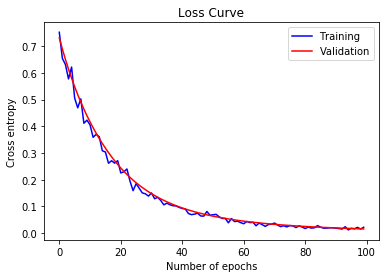

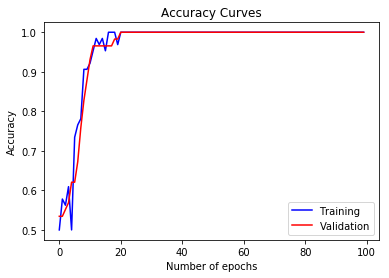

In [83]:
plt.figure()
plt.plot(train_loss, color='b', label='Training')
plt.plot(valid_loss, color='r', label='Validation')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Number of epochs')
plt.ylabel('Cross entropy')

plt.figure()
plt.plot(train_acc, color='b', label='Training')
plt.plot(valid_acc, color='r', label='Validation')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')